In [1]:
import numpy as np
from scipy.integrate import solve_bvp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import animation

animation.writer = animation.writers['ffmpeg']

In [4]:
def lunar_lander(pos_init, v_init, alpha=10., beta=25., gamma=3., G=2., t_steps=200, animate_file=None):
    '''Find the optimal control and trajectory for the lunar lander.

        Parameters:
            pos_init (tuple) : x and y coordinates defining the starting position of the lunar lander
            v_init (float) : the lander's starting velocity in the x direction
            alpha (float) : the weight on the magnitude of the lander's acceleration over time
            beta (float) : the weight on the magnitude of the lander's final velocity (both x and y directions)
            gamma (float) : the weight on the final time
            G (float) : acceleration due to gravity on the moon
            t_steps : number of time steps to evaluate
            animate_file : if a string filename is passed in, an animation will be created and saved in the 
                specified file name. If no filename is passed in, the function will return without creating an
                animation
        
        Returns: 
            t_vals (ndarray) : the time values corresponding with the solution values
            x (ndarray) : the lander's trajectory (position) in the x direction
            y (ndarray) : the lander's trajectory (position) in the y direction
            xp (ndarray) : the lander's velocity in the x direction
            yp (ndarray) : the lander's velocity in the y direction
            ux (ndarray) : the optimal control (acceleration) in the x direction
            uy (ndarray) : the optimal control (acceleration) in the y direction
            tf (float) : the optimal landing time
    '''

    x_init, y_init = pos_init

    # Define the ODE's associated with state and costate evolution
    def ode(t, y, p):
        tf = p[0]
        return tf * np.array([
            y[2],
            y[3],
            y[6] / (2*alpha),
            y[7] / (2*alpha) - G,
            np.zeros_like(y[0]), 
            np.zeros_like(y[0]), 
            y[4],
            y[5]
        ])
    
    # Define the boundary conditions
    # BC's 1-5 come from known initial and final conditions
    # BC's 6-8 come from conditions on the costate
    # BC 9 comes from the final condition on the Hamiltonian relating to variable final time
    def bc(ya, yb, p):
        tf = p[0]
        uxf = yb[6] / (2*alpha)
        uyf = yb[7] / (2*alpha)
        return np.array([
            ya[0] - x_init,
            ya[1] - y_init,
            ya[2] - v_init,
            ya[3],
            yb[1],
            yb[4],
            yb[6] - 2*beta*yb[2],
            yb[7] - 2*beta*yb[3],
            yb[4]*yb[2] + yb[5]*yb[3] + yb[6]*uxf + yb[7]*(uyf - G) - alpha*(uxf**2 + uyf**2) + gamma
        ])
    
    # Define the initial guess
    tf_0 = 20
    t_eval = np.linspace(0, 1, t_steps) 
    y0 = np.ones((8, t_steps))

    y0[0] *= x_init                            # x constant
    y0[1] = np.linspace(y_init, 0, t_steps)    # y goes to 0
    y0[2] = np.linspace(v_init, 0, t_steps)    # vx goes to 0
    

    # Solve the ODE
    sol = solve_bvp(ode, bc, t_eval, y0, p=np.array([tf_0]), max_nodes=30000)
    tf = sol.p[0]

    # Extract the different elements of the solution
    x = sol.y[0]
    y = sol.y[1]
    xp = sol.y[2]
    yp = sol.y[3]
    ux = sol.y[6] / (2*alpha)       # compute controls from costates
    uy = sol.y[7] / (2*alpha)
    t_vals = sol.x * tf

    # Animate the solution
    if animate_file is not None: 
        fig, ax = plt.subplots()
        ax.set_xlim(np.min(x)-0.5, np.max(x)+0.5)
        ax.set_ylim(0, np.max(y)+0.5)

        def animate(t):
            ax.clear()
            ax.set_xlim(np.min(x)-0.5, np.max(x)+0.5)
            ax.set_ylim(0, np.max(y)+0.5)
            line = ax.plot(x[:t], y[:t])
            return line
        
        n = len(x)
        ani = FuncAnimation(fig, animate, frames=np.arange(n), interval=5)
        
        ani.save(animate_file)

    return t_vals, x, y, xp, yp, ux, uy, tf

pos = (5., 10.)
v = 1.

t, x, y, xp, yp, ux, uy, tf = lunar_lander(pos, v)
print(tf)

3.9026390702356926


3.9026390702356926


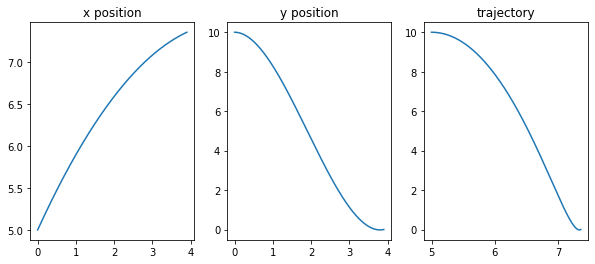

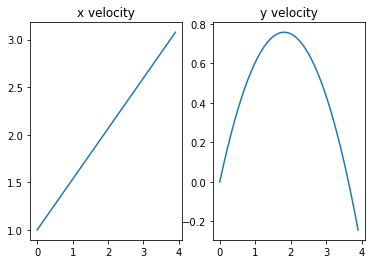

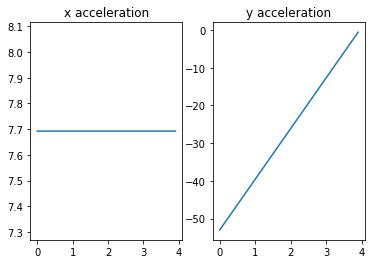

In [3]:
print(tf)
plt.figure(figsize=(10, 4))
plt.subplot(131)
plt.plot(t, x)
plt.title("x position")
plt.subplot(132)
plt.plot(t, y)
plt.title("y position")
plt.subplot(133)
plt.plot(x, y)
plt.title("trajectory")
plt.show()

plt.subplot(121)
plt.plot(t, xp)
plt.title("x velocity")
plt.subplot(122)
plt.plot(t, yp)
plt.title("y velocity")
plt.show()

plt.subplot(121)
plt.plot(t, ux)
plt.title("x acceleration")
plt.subplot(122)
plt.plot(t, uy)
plt.title("y acceleration")
plt.show()
